In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [11]:

# load libraries
from FRVRS import (nu, fu, Series, DataFrame)


## Use the CSV Data from the Last Successful Build

In [4]:

# load the CSV data frame from the last successful build
df_name = 'csv_stats_df'
data_frames_dict = nu.load_data_frames(
    verbose=True, **{df_name: ''}
)
csv_stats_df = data_frames_dict[df_name].copy()
print(csv_stats_df.shape)
print(sorted([cn for cn in csv_stats_df.columns if 'patient_id' in cn]))

No pickle exists for csv_stats_df - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/csv_stats_df.csv.
(158663, 125)
['injury_record_patient_id', 'injury_treated_patient_id', 'patient_id', 'player_gaze_patient_id', 'pulse_taken_patient_id', 'tag_applied_patient_id', 'tool_applied_patient_id', 'triage_level_walk_if_can_patient_id', 'triage_level_walked_patient_id', 'triage_level_wave_if_can_patient_id', 'triage_level_waved_patient_id']



## Use the is-military classifier to give every patient a value between 0 and 1

In [5]:

# Load the pretrained classifer, vectorizor, and transformer
is_military_classifier = nu.load_object('is_military_classifier')
is_military_tt = nu.load_object('is_military_tt')
is_military_cv = nu.load_object('is_military_cv')

In [6]:

# Add a column to give every patient a value between 0 and 1
for patient_id, patients_df in csv_stats_df.groupby('patient_id'):
    if any(map(lambda x: x in patient_id.lower(), ['civilian'])):
        is_military = 0.0
    elif any(map(lambda x: x in patient_id.lower(), ['officer', 'soldier', 'marine', 'military', 'navy'])):
        is_military = 1.0
    else:
        
        # Predict if its military
        X_test = is_military_tt.transform(is_military_cv.transform([patient_id])).toarray()
        is_military = is_military_classifier.predict_proba(X_test)[0][1]
    
    # Store the prediction in the predict_proba column
    csv_stats_df.loc[patients_df.index, 'is_military_prediction'] = is_military


### Test it on every patient

In [7]:

# Show the list of military patients
mask_series = (csv_stats_df.is_military_prediction == 1.0) & ~csv_stats_df.patient_id.isnull()
sorted(csv_stats_df[mask_series].patient_id.unique())

['Local Soldier 1 Root', 'Marine 1 Male Root', 'Marine 2 Male Root', 'Marine 3 Male Root', 'Marine 4 Male Root', 'Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root', 'Open World Marine 1 Female Root', 'Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 2 Male Root', 'Open World Marine 3 Male Root', 'Open World Marine 4 Male Root', 'US Soldier 1 Root']

In [8]:

# Show the list of non-military patients
mask_series = (csv_stats_df.is_military_prediction == 0.0) & ~csv_stats_df.patient_id.isnull()
sorted(csv_stats_df[mask_series].patient_id.unique())

['Adept Shooter Root', 'Adept Victim Root', 'Civilian 1 Female Root', 'Civilian 1 Root', 'Civilian 2 Root', 'NPC 1 Root', 'NPC 2 Root', 'NPC 3 Root', 'NPC 4 Root', 'NPC Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root', 'Patient U Root', 'Patient V Root', 'Patient W Root', 'Patient X Root', 'Simulation Root', 'bystander Root', 'electrician Root', 'patient U Root', 'patient V Root', 'patient W Root', 'patient X Root']

In [9]:

# Show the list of edge cases
mask_series = (csv_stats_df.is_military_prediction < 1.0) & (csv_stats_df.is_military_prediction > 0.0) & ~csv_stats_df.patient_id.isnull()
sorted(csv_stats_df[mask_series].patient_id.unique())

[]


## Calculate the measure for every session and display a histogram

In [14]:

# Calculate the R-squared adjusted value as a measure of right ordering for every session
rows_list = []
groupby_columns = ['participant_id', 'session_uuid']
for (participant_id, session_uuid), session_df in csv_stats_df.groupby(groupby_columns):
    row_dict = {cn: eval(cn) for cn in groupby_columns}
    
    # Extract the actual and ideal sequences of first interactions from the scene in terms of is/isn't military
    engagement_starts_list = fu.get_actual_engagement_order(session_df)
    actual_sequence = []
    for engagement_tuple in engagement_starts_list:
        patient_id = engagement_tuple[0]
        if any(map(lambda x: x in patient_id.lower(), ['civilian'])):
            is_military = 0.0
        elif any(map(lambda x: x in patient_id.lower(), ['officer', 'soldier', 'marine', 'military', 'navy'])):
            is_military = 1.0
        else:
            X_test = is_military_tt.transform(is_military_cv.transform([patient_id])).toarray()
            is_military = is_military_classifier.predict_proba(X_test)[0][1]
        actual_sequence.append(is_military)
    ideal_sequence = sorted(actual_sequence)[::-1]
    
    # Calculate the R-squared adjusted value as a measure of right ordering
    measure_of_right_ordering = fu.get_measure_of_ordering(Series(actual_sequence), Series(ideal_sequence))
    row_dict['measure_of_right_ordering'] = measure_of_right_ordering

    rows_list.append(row_dict)
right_ordering_df = DataFrame(rows_list)

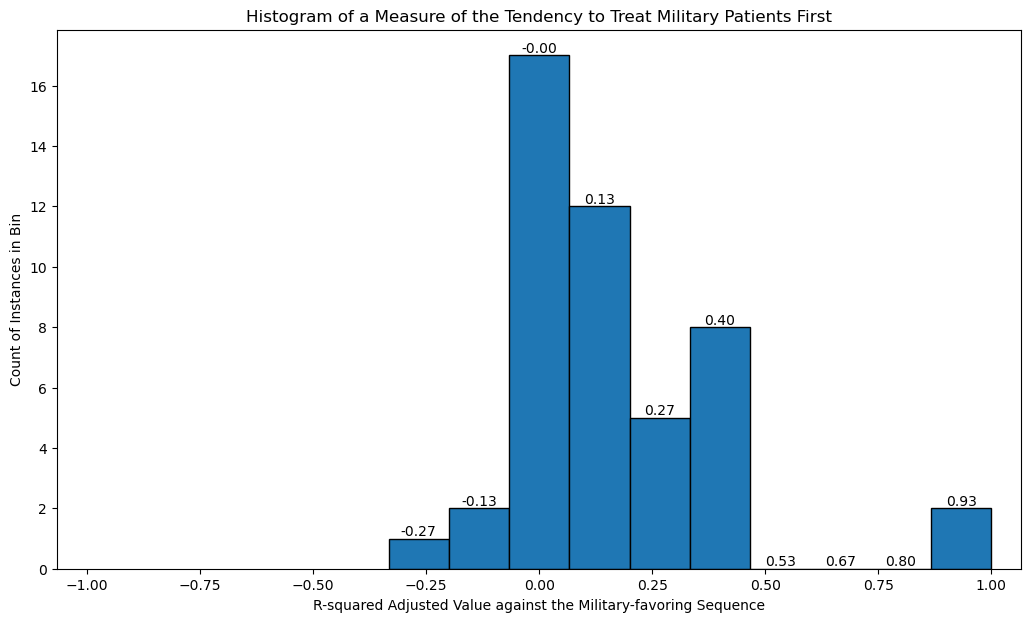

In [16]:

# Show a histogram of the measure
from matplotlib import pyplot as plt
fig_height = 7
fig_size=(nu.twitter_aspect_ratio*fig_height, fig_height)
fig, ax = plt.subplots(figsize=fig_size)
axes_subplot_obj = right_ordering_df.measure_of_right_ordering.hist(ax=ax, align='mid', edgecolor='black')

# Display x value of each bar on bar
bars_collection = axes_subplot_obj.patches
for rect in bars_collection:
    height = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2.0
    ax.text(x_value, height, f'{x_value:0.2f}', ha='center', va='bottom')

# Set the grid, title, and labels
plt.grid(False)
ax.set_title('Histogram of a Measure of the Tendency to Treat Military Patients First')
ax.set_xlabel('R-squared Adjusted Value against the Military-favoring Sequence')
ax.set_ylabel('Count of Instances in Bin')

left_lim, right_lim = ax.get_xlim()
xlim_tuple = ax.set_xlim(left=-right_lim, right=right_lim)